# Evolution of Reggae into Dub into Dubstep

## Corpus

We are going to look at a set of three playlists. They are called:

'<b>Old School Reggae Roots 70s/80s</b>' (300 tracks)<br>
'<b>Heavy roots dub reggae</b>' (317 tracks)<br>
'<b>DEEP MEDi MUSIK & Tempa Records .. deep</b>' (617 tracks)

These are all playlists of styles of music that are somhow connected. The theory is that dub (2nd playlist) evolved from reggae (1st playlist), and dupstep (3rd playlist) evolved from dub. Therefore these three playlist represent the 'evolution of reggae into dubstep'. 

Spotify has an API that will allow us to gather their analysis on all of their tracks. We will use this to create a dataset of features of all the tracks in our corpus

Note: We are not talking about the 'brostep' genre, commonly referred to as dubstep. brostep artists include Skrillex and Datsik.

## Hypotheses

We want to see if we can somehow find a 'shift' in these playlists. That is, the distribution of Spotify's features of these three playlists follow some path. So our main hypothesis is: dub forms the bridge between reggae and dubstep.

This means that we want to see if we can find a certain 'shift' in the spotify features.

Sub-hypotheses:

1. We can see for example, that reggae is traditionally played on acoustic or amplified musical intruments, dub songs are often a re-mix of the individual tracks of a reggae song, using a lot of (analogue) effects, and dubstep is usually entirely electronically/digitally produced. Because of this, we expect to see some decrease in the 'acousticness' feature in these playlists.

2. We can also argue that the instrumentalness will increase. Reggae usually has vocals, where dubstep typically doesn't.

3. Reggae is usually seen as happy and uplifting music, while dubstep is seen as dark and maybe even angry music. We will look for some patttern describing a shit in the valence of the music.

## Setting up
First we need get our corpus from the Spotify API. In a file called `util.py`, we've defined some helper functions to load all this data in batches, to keep the amount of code in this notebook to a minimum. 

First we need to do some imports, then we will load the track features of the  playlists and save them in pandas dataframes.

In [12]:
### imports
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import chart_studio.plotly as py

import pandas as pd
import numpy as np
from sklearn.manifold import TSNE

import util

In [2]:
playlists = ["reggae", "dub", "dubstep"]

p1_name, p1_tracks, p1_link = util.collect_tracks_query("old school reggae roots", "playlist")
df1 = util.get_tracklist_features(p1_tracks)#.set_index("id")
df1["playlist"] = playlists[0]
print(f"Playlist analysis: {util.wrap_spotify_link(p1_name, p1_link)}, with {len(p1_tracks)} tracks")

p2_name, p2_tracks, p2_link = util.collect_tracks_query("heavy dub roots reggae", "playlist")
df2 = util.get_tracklist_features(p2_tracks)#.set_index("id")
df2["playlist"] = playlists[1]
print(f"Playlist analysis: {util.wrap_spotify_link(p2_name, p2_link)}, with {len(p2_tracks)} tracks")

p3_name, p3_tracks, p3_link = util.collect_tracks_query("deep medi musik", "playlist")
df3 = util.get_tracklist_features(p3_tracks)#.set_index("id")
df3["playlist"] = playlists[2]
print(f"Playlist analysis: {util.wrap_spotify_link(p3_name, p3_link)}, with {len(p3_tracks)} tracks")

df = pd.concat([df1, df2, df3]).drop(["uri", "track_href", "analysis_url", "type"], axis=1)
del df1, df2, df3

print("A view of what the data looks like: ")
df.head()

Playlist analysis: <a href="https://open.spotify.com/playlist/3RR3JllftMFHL4W0UwwuYG">Old School Reggae Roots 70s/80s</a>, with 378 tracks
Playlist analysis: <a href="https://open.spotify.com/playlist/38KbybQIykgGa5IS9EfzpG">Heavy Dub Roots Reggae</a>, with 835 tracks
Playlist analysis: <a href="https://open.spotify.com/playlist/1NcfnV0Ks8nwOabcjErqRZ">DEEP MEDi MUSIK & Tempa Records .. deep</a>, with 617 tracks
A view of what the data looks like: 


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,name,playlist
0,0.866,0.548,0,-10.064,1,0.2610,0.078500,0.272000,0.0794,0.579,142.752,4Qmbc7KFWkKvxBz5KjcA6g,233160,4,Barrington Levy - Murderer,reggae
1,0.719,0.578,5,-7.503,1,0.0520,0.028400,0.000168,0.2680,0.675,145.308,3nySNL3ZD64jc27oZDsvvK,353373,4,"Eek-A-Mouse - For Hire and Removal - 12"" Mix",reggae
2,0.696,0.799,5,-9.467,0,0.0458,0.000539,0.000279,0.1820,0.872,144.470,707TD3SiORrVrlkenC9Qvi,216093,4,Half Pint - Greetings,reggae
3,0.699,0.405,10,-10.492,1,0.0741,0.027200,0.000010,0.1040,0.769,145.346,76XSm0fCTRHKGbfPhPopE4,206067,4,Sugar Minott - Dancehall Stylee,reggae
4,0.766,0.677,11,-6.685,0,0.0751,0.071700,0.000000,0.2690,0.855,149.591,3p41ArtexPuFkL56twTQ2Y,155635,4,Horace Andy - Cus Cus,reggae


### Iconic tracks

Before we try to test our hypotheses, we should have an intuitive feeling of what kind of music we are actually working with. We are going to look at what the most typical/iconic tracks are according to each playlist, as well as the least typical. This will give us a way to verify that the features exctracted by Spotify can actually be used to accurately represent a track of a certain genre, and if you're not familiar witht the music, it will give you some idea of what we're working with. If we can indeed verify the 'most iconic tracks' as typical tracks for each genre, we know these features are saying something. 

We'll do this by calculating some distance measure for each track to the 'golden standard' for that playlist, defined by the feature vector consisting of the means.

We will use euclidean distance.

In [3]:
features = [
    "danceability",
    "energy",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence"
]

# we temporarily disable the setting on a copy warning, since that is what we want to do in this case
pd.set_option('mode.chained_assignment', None)
    
def most_iconic_track(df):
    golden_standard = df[features].mean()

    # euclidean distance:
    df["distance"] = (df[features] - golden_standard).pow(2).sum(axis=1).pow(0.5)
    closest_song_id = df[df['distance'] == df['distance'].min()]["id"].values[0]

    closest_track = util.sp.track(closest_song_id)
    return closest_track

def least_iconic_track(df):
    golden_standard = df[features].mean()

    # euclidean distance:
    df["distance"] = (df[features] - golden_standard).pow(2).sum(axis=1).pow(0.5)
    furthest_song_id = df[df['distance'] == df['distance'].max()]["id"].values[0]

    furthest_track = util.sp.track(furthest_song_id)
    return furthest_track

for pl in playlists:
    track = most_iconic_track(df[df["playlist"] == pl])
    print(util.wrap_spotify_link_track(track))
    track = least_iconic_track(df[df["playlist"] == pl])
    print(util.wrap_spotify_link_track(track))
    print('\n')

pd.set_option('mode.chained_assignment', 'warn')

<a href="https://open.spotify.com/track/3GRuCJ60jozCdIYrdbnu8K">Baba Boom Time - Original by The Jamaicans</a>
<a href="https://open.spotify.com/track/4i15K683cnuoFJqdhvEK3E">Why Did You Leave by The Heptones</a>


<a href="https://open.spotify.com/track/3C88onjSPfnDW2xgDGmKRg">Taxi to Baltimore Dub by Scientist</a>
<a href="https://open.spotify.com/track/1VVLIiLmW0j4jjuUP7i6Lr">Conquering Lion - Dub Plate Mix by Yabby You</a>


<a href="https://open.spotify.com/track/53ztteLLPc0kNWXVDKQFFW">Wobble That Gut by Skream</a>
<a href="https://open.spotify.com/track/4BJHlDxJvP9mudno9uklWX">A Song For Lenny by Skream</a>




If you listen to these tracks (and you have some notion of what typical reggae, dub and dubstep songs sound like), you will notice that the iconic tracks are indeed very iconic, and the least iconic tracks are indeed not very representable for the genre they where placed in.

## Visualization

We want to have a good idea of what our corpus looks like. We will generate some histograms of the three playlists for each feature. We will also plot the means for each playlist. This should give us not only an idea of how the features playlists are distributed, but also how the different playlists relate.

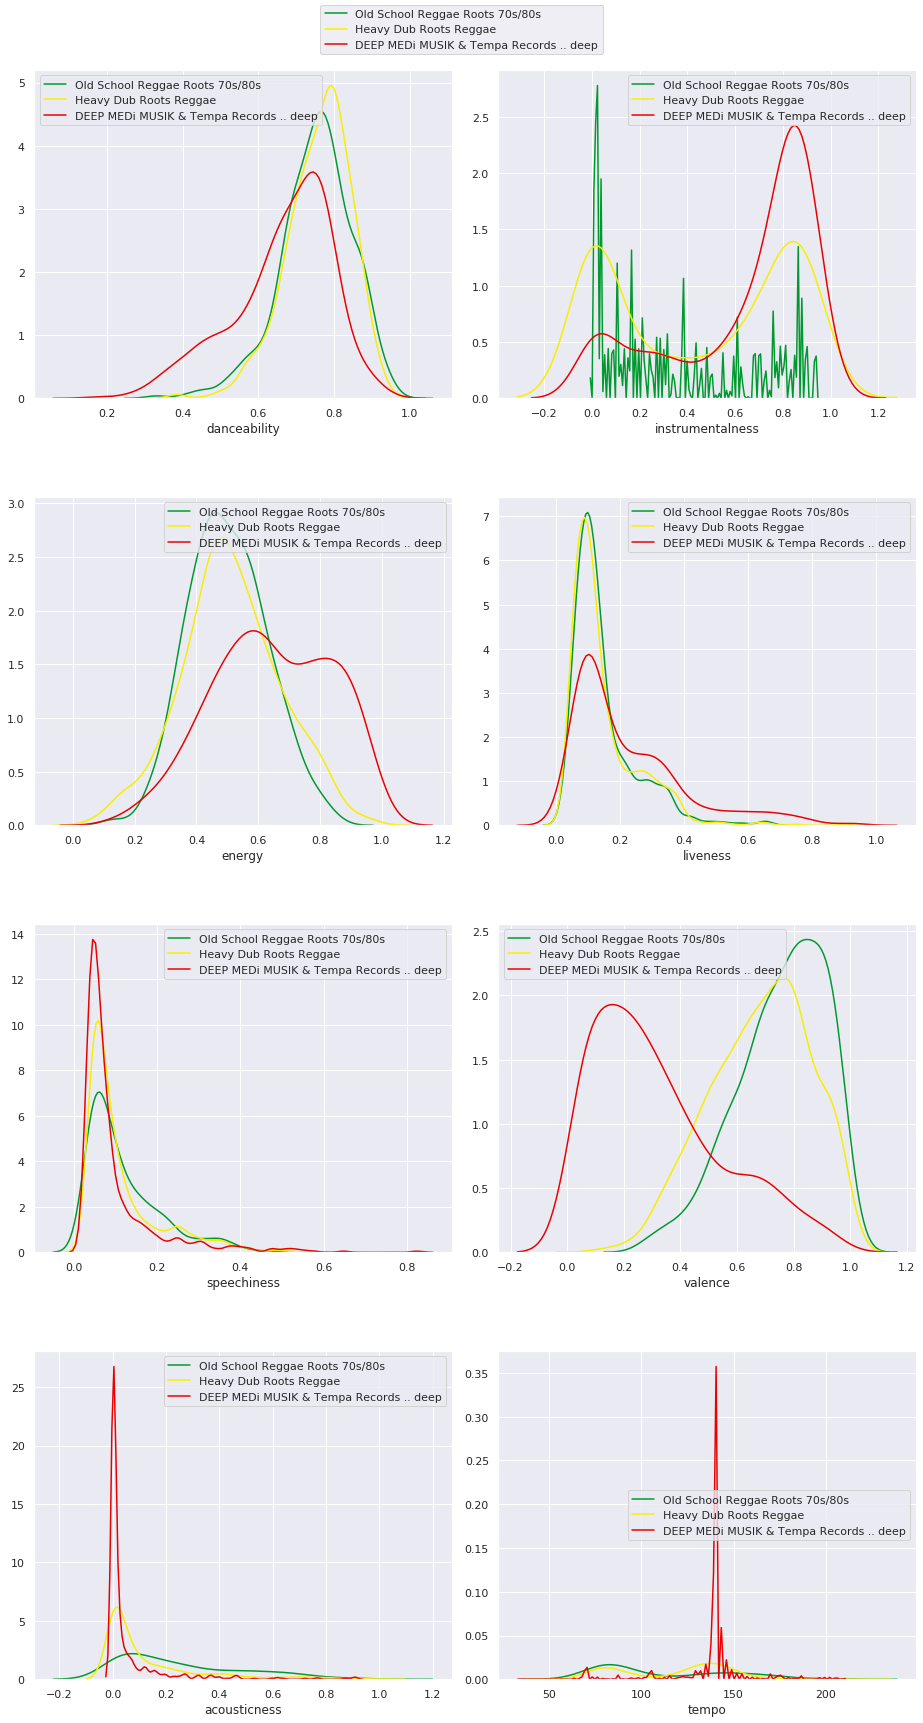

In [11]:
### Vizualization
# Now that we've loaded all the features in our playlist, we want to visually analyze the 
# results. We define a list with all the features we want to look at, including the ranges
# the values will be in.
###

interesting_features = [
    'danceability',
    'energy',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo'
]

### Plots
# we will generate 10 histograms, one for each interesting feature, each histogram holds
# the distributions of that feature of each playlist, seperated by different colors.

sns.set(rc={'figure.figsize':(13,24)})
fig, axs = plt.subplots(4, 2)

df1 = df[df["playlist"] == "reggae"]
df2 = df[df["playlist"] == "dub"]
df3 = df[df["playlist"] == "dubstep"]

for i in range(4):
    for j in range(2):
        ft = interesting_features[i + (4*j)]
        
        # the colors of eacht plot are based on the flag of ethiopia (rastafari flag)
        sns.distplot(df1[ft], label=p1_name, ax=axs[i, j], color="#00992f", hist=False)
        sns.distplot(df2[ft], label=p2_name, ax=axs[i, j], color="#f7ee00", hist=False)
        sns.distplot(df3[ft], label=p3_name, ax=axs[i, j], color="#eb0000", hist=False)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
fig.tight_layout()
plt.subplots_adjust(hspace = 0.3, top=0.96)

### Clustering

We want some way to actually see how these playlists are represented by the track features. If we see the feature vectors as points in 7-dimensional space, we can create a scatterplot showing all tracks. Of course we can't see 7 dimensions, so we need to perform some dimensionality redution. There is an array of methods to use. Based on some trial and error, the t-SNE method was chosen. (See `clustering_viz.ipynb` for an example of all the methods).

In [10]:
tsne = TSNE(n_components=3, perplexity=80)
components = tsne.fit_transform(df[features].values)

df["component1"] = components[:, 0]
df["component2"] = components[:, 1]
df["component3"] = components[:, 2]

In [13]:
fig = px.scatter_3d(df.dropna(), x="component1", y="component2", z="component3", hover_name="name", color="playlist",
          color_discrete_sequence = ["#00992f", "#f7ee00", "#eb0000"], size_max=5, size=[1]*df.dropna().shape[0])

fig.update_layout(
    autosize=False,
    width=850,
    height=800
)

py.iplot(fig, filename="tsne-scatter")

Now these are some very interesting results. Not only can we see that the spotify features are adequate to differentiate between the three genres. Though there is a lot of overlap, this is to be expected. Certainly dub anr reggae are overlapping a lot, and dub and dubstep also. This supports the theory that dub is the bridge between the two other genres. 

What is an unexpected result is that all the tracks seem to be devided in two clusters, not the expected three. Both dub and dubstep seem to lie in both clusters, where reggae seems to be confined to only one. Our next task will be figuring out which features 'define' this seperations. We have to somehow infer back through our dimensionality reduction. 

First, let's define what these clusters are. We will use k-means clustering, an algorithm to find clusters in data, to learn for each track in which cluster they belong.

In [14]:
def distance(p1, p2):
    return np.linalg.norm(p1 - p2) # euclidean distance

def k_means(points, n, iterations=5):
    """
    k-means algorithm for clustering data (of any dimension)
    
    args:
        points : np.array
            numpy array of points, dimensions (ndimensions, npoints)
        n : int
            number of clusters to look for
        iterations : int, optional (default: 5)
            number of iterations before stopping the algorithm
    returns:
        clusters : list of np.arrays
            list of np arrays, each array holds the indices of points of a cluster
    """
    
    # start by choosing means as random points from the data
    mean_indices = np.random.randint(0, len(points), n)
    means = points[mean_indices]
    
    for _ in range(iterations):
        clusters = {i: [] for i in range(n)}
        for i, point in enumerate(points):
            # keep track of closest mean for each point
            best_dist = float('inf')
            best_mean = None
            for mean_i in clusters:
                # check distance from point to each cluster
                d = distance(point, means[mean_i])
                if d < best_dist:
                    best_dist = d
                    best_mean = mean_i
            # add point to cluster of the closest mean
            clusters[best_mean].append(i)
        
        # set all the means to the mean of the clusters
        for mean_i in clusters:
            means[mean_i] = points[clusters[mean_i]].mean(axis=0)
    
    # return list of np arrays, each array holds the indices of points of a cluster
    return [clusters[mean_i] for mean_i in range(n)]



points = df[["component1", "component2", "component3"]].dropna().values
clusters = k_means(points, 2, 5)

cluster_array = np.zeros(shape=(sum([len(cluster) for cluster in clusters]), ), dtype=str)
cluster_array[clusters[0]] = '2'
cluster_array[clusters[1]] = '1'

df["cluster"] = cluster_array

fig = px.scatter_3d(df.dropna(), x="component1", y="component2", z="component3", hover_name="name", 
                   color="cluster", size_max=5, size=[1]*df.dropna().shape[0])

fig.update_layout(
    autosize=False,
    width=850,
    height=800
)

py.iplot(fig, filename="k-means-scatter")

We have now seperated our dataset again, this time based on the clusters we found. Now let's think of ways to find which features define those clusters. One way we can do this is by comparing the histograms of each feature in this new dataset.

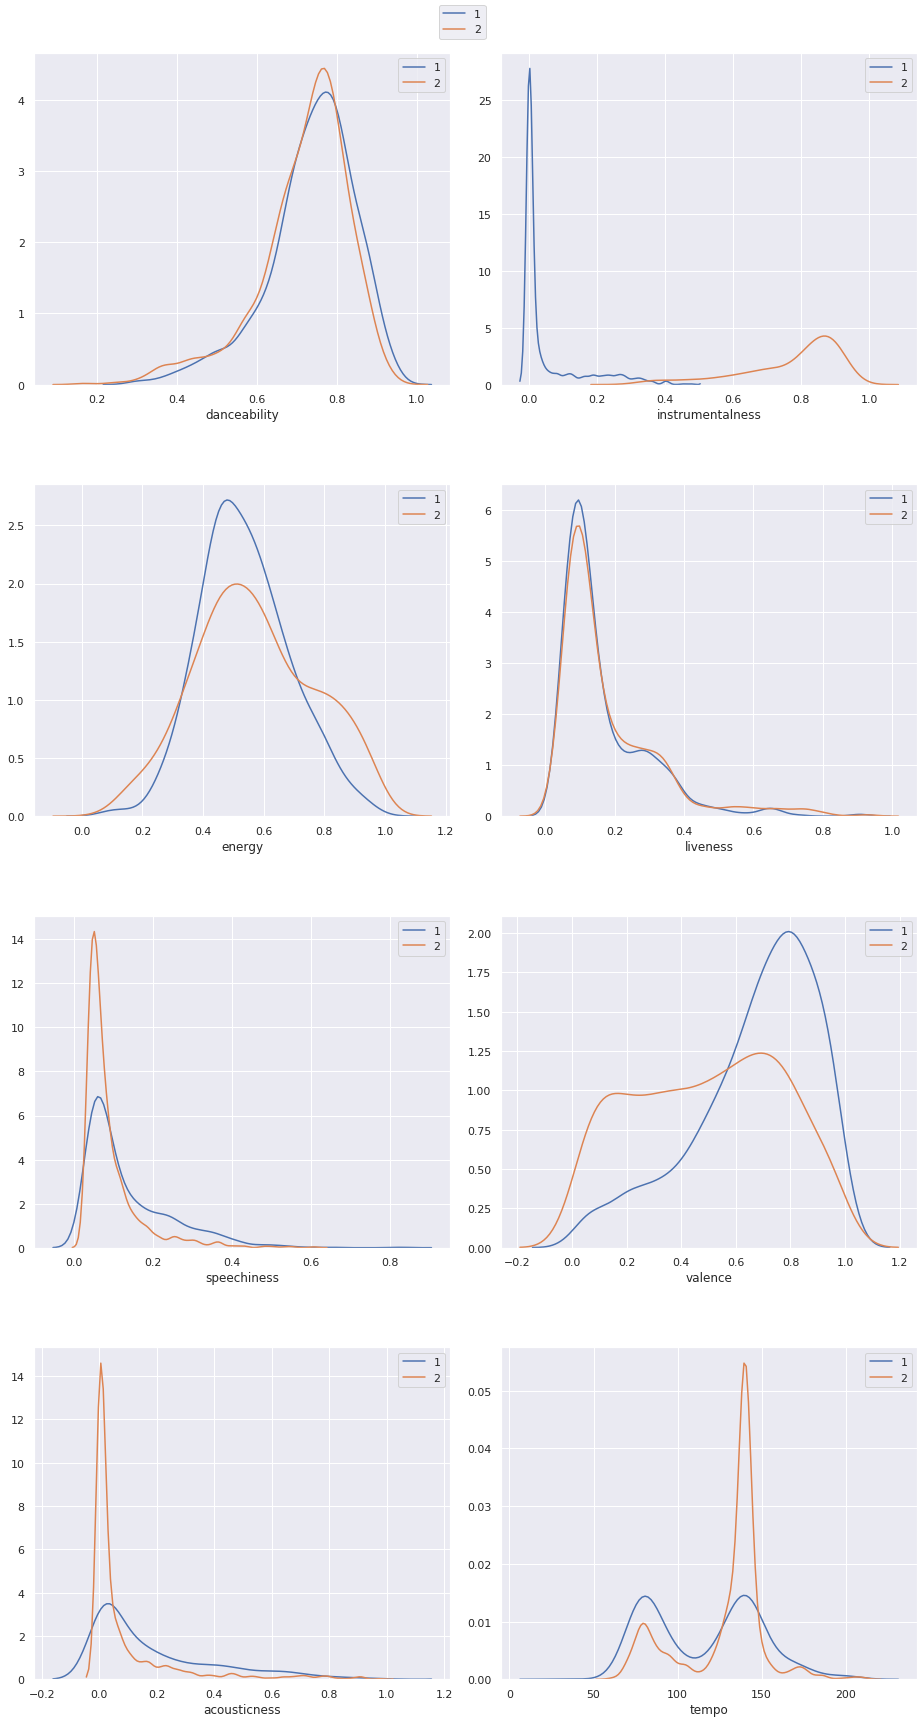

In [15]:
sns.set(rc={'figure.figsize':(13,24)})
fig, axs = plt.subplots(4, 2)

df1 = df[df["cluster"] == "1"]
df2 = df[df["cluster"] == "2"]

for i in range(4):
    for j in range(2):
        ft = interesting_features[i + (4*j)]
        
        # the colors of eacht plot are based on the flag of ethiopia (rastafari flag)
        sns.distplot(df1[ft], label="1", ax=axs[i, j], hist=False)
        sns.distplot(df2[ft], label="2", ax=axs[i, j], hist=False)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
fig.tight_layout()
plt.subplots_adjust(hspace = 0.3, top=0.97)

As we can see, most features line up almost perfectly, with a few exceptions. Most notably, the instrumentalness. This should of course not come as a surprise. Some other differences are speechiness and valence.

We can now check if just these features are enough to recreate a similair looking plot. Here we see a scatterplot of all tracks of acousticness and valence, and although it looks much less pretty, a similair pattern can be found.

In [17]:
fig = px.scatter_3d(df.dropna(), x="instrumentalness", y="valence", z="acousticness", hover_name="name", 
                    color="playlist",
          color_discrete_sequence = ["#00992f", "#f7ee00", "#eb0000"], size_max=5, size=[1]*df.dropna().shape[0])

fig.update_layout(
    autosize=False,
    width=850,
    height=800
)

py.iplot(fig, filename="features-scatter")

These findings to conform to the hypothesis that dub is the bridge between reggae and dubstep, In the figure above we can clearly see reggae holds the top left corner and dubstep the bottom right.